Mean mean ([30.65785416  0.18130021  0.57752095]) nm
Mean std ([22.1540496   9.80619657 10.92293577]) nm


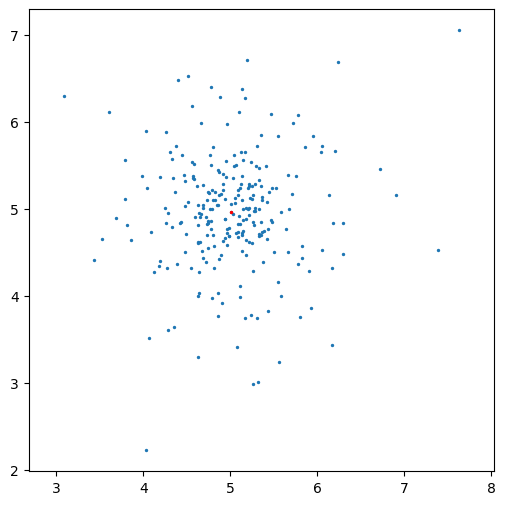

In [1]:
""" resolution
"""

import numpy as np
import scipy.optimize
import tifffile
import matplotlib.pyplot as plt

frame_load_path = "data/tubulin/8-(00-32-00-32)-e10-(08-12-09-13)-RCC/45000.tif"
# pos getting by Multi-Point and Analyze-Measure in ImageJ 
# 0-based for XY and 1-based for Z
pos_load_path = "data/resolution-pos.csv"
result_save_path = "data/resolution-result.csv"
edge = 5

# note that this position is direct read from ImageJ, 0-based
# load csv file
positions = np.loadtxt(pos_load_path, delimiter=',', skiprows=1)
# remove first four columns, round data to int and print
positions = np.round(positions[:, 5:]).astype(int)
# order of columns from XYZ to ZYX
positions = positions[:, [2, 1, 0]]

def gaussian_3d(coords, A, z0, y0, x0, sigma_z, sigma_y, sigma_x):
    z, y, x = coords
    return A * np.exp(-(
        ((z - z0) ** 2) / (2 * sigma_z ** 2) +
        ((y - y0) ** 2) / (2 * sigma_y ** 2) +
        ((x - x0) ** 2) / (2 * sigma_x ** 2)
    ))

# create a size*size*size coordinate grid
coords = np.meshgrid(*(np.arange(2*edge+1),) * 3, indexing='ij')
coords_flat = tuple(map(np.ravel, coords))

frame = tifffile.imread(frame_load_path)
result = []
for pos in positions:
    # cut cube around the position
    cube = frame[
        pos[0]-edge : pos[0]+edge+1, 
        pos[1]-edge : pos[1]+edge+1, 
        pos[2]-edge : pos[2]+edge+1,
    ]
    # perform Gaussian fit
    popt, _ = scipy.optimize.curve_fit(
        gaussian_3d, coords_flat, cube.ravel(), 
        p0=[1, edge, edge, edge, 1, 1, 1],
        bounds=(
            [0, 0, 0, 0, 0.01, 0.01, 0.01], 
            [np.inf, 2*edge, 2*edge, 2*edge, np.inf, np.inf, np.inf]
        )
    )
    A_fit, z0_fit, y0_fit, x0_fit, std_z, std_y, std_x = popt
    result.append([
        pos[0], pos[1], pos[2], 
        A_fit, 
        z0_fit, y0_fit, x0_fit, 
        std_z, std_y, std_x
    ])
result = np.array(result)

# save result as Analysis.csv
np.savetxt(
    result_save_path, result, delimiter=',', 
    header="Z,Y,X,A,Z0,Y0,X0,STD_Z,STD_Y,STD_X"
)

# print mean and std of the results
mean_mean_px = np.abs(edge - np.mean(result[:, 4:7], axis=0))
mean_mean_nm = mean_mean_px * np.array([130/4, 130/8, 130/8])
mean_std_px = np.std(result[:, 4:7], axis=0)
mean_std_nm = mean_std_px * np.array([130/4, 130/8, 130/8])
print(f"Mean mean ({mean_mean_nm}) nm")
print(f"Mean std ({mean_std_nm}) nm")

# plot the results
plt.figure(figsize=(6, 6))
plt.scatter(result[:, 4:7][:, 1], result[:, 4:7][:, 2], s=2)
plt.scatter(
    np.mean(result[:, 4:7], axis=0)[1], 
    np.mean(result[:, 4:7], axis=0)[2], c='r', s=2
)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.axis('equal')
plt.show()

In [ ]:
""" mlist2label 
"""

import torch
from torch import Tensor
import numpy as np
import os
import tifffile
import h5py
import scipy.io
import tqdm

# dimensional config
dim_frame = Tensor([ 32, 512, 512]).int()   # (C, H, W), (130, 130, 130)nm
up_sample = Tensor([  4,   8,   8]).int()   # (C, H, W)
dim_label = dim_frame * up_sample
# data path
data_fold = "C:/Users/tianrui/Desktop/tubulin/"
frames_load_fold = data_fold + "frames"
mlists_load_fold = data_fold + "mlists"
data_save_fold   = data_fold + "8-(00-32-00-32)-ml-tempaverage-RCC"
temp_save_fold   = data_fold + "tempaverage"
method = "RCC"  # DCC, MCC, or RCC

# file name list
frames_list = os.listdir(frames_load_fold)
mlists_list = os.listdir(mlists_load_fold)
# create folder
if not os.path.exists(data_save_fold): os.makedirs(data_save_fold)

# drift
drift  = torch.from_numpy(np.loadtxt(
    os.path.join(temp_save_fold, "{}.csv".format(method)), delimiter=','
)).float()
drift *= up_sample / Tensor([4, 4, 4]).int()
drift  = drift.round().int()

result = torch.zeros(*dim_label.tolist())
for index in tqdm.tqdm(
    range(len(frames_list)), desc=data_save_fold, unit="frame"
):
    mlist = None
    try:
        with h5py.File(os.path.join(
            mlists_load_fold, mlists_list[index]
        ), 'r') as file: mlist = file['storm_coords'][()].T
    except OSError:
        _, mlist = scipy.io.loadmat(
            os.path.join(mlists_load_fold, mlists_list[index])
        ).popitem()
    mlist = torch.from_numpy(mlist).float()

    # up sample the molecular list
    mlist[:, 0:3]  = (mlist[:, 0:3] + 0.5) * up_sample - 0.5
    # drift correction for molecular list
    mlist[:, 0:3] += drift[index]
    # round and clip
    mlist[:, 0:3]  = torch.round(mlist[:, 0:3])
    mlist[:, 0:3]  = torch.clip(
        mlist[:, 0:3], torch.zeros_like(dim_label), dim_label - 1
    )

    # remove false fitting
    mlist[mlist[:, 6] > 50, 6] = 0

    # label
    for i in range(mlist.shape[0]):
        mean = mlist[i, 0:3]
        peak = mlist[i, 6]
        #peak = torch.clip(mlist[i, 6], 0, 1)
        result[tuple(mean.int())] += peak

    # save after combine 1, 2, 4, 8, 16... frames
    #current_frame = index + 1
    #if current_frame & (current_frame - 1) == 0 or index == len(frames_list)-1:
    #    tifffile.imwrite(
    #        "{}/{:05}.tif".format(data_save_fold, current_frame),
    #        result.numpy()
    #    )
tifffile.imwrite(
    "{}/{:05}.tif".format(data_save_fold, len(frames_list)),
    result.numpy()
)

In [ ]:
""" put subframes into whole frame
"""

import numpy as np
import tifffile
import os
import tqdm

rng_sub_user = [0, 1, 26, 27, 18, 22]

dim_label = np.array([32*4, 512*8, 512*8]).astype(int)
frame_fold = f"D:/8-({rng_sub_user[2]:02d}-{rng_sub_user[3]:02d}-{rng_sub_user[4]:02d}-{rng_sub_user[5]:02d})-e10-(08-12-09-13)-RCC-3D"
whole_fold =  "C:/Users/tianrui/Desktop/8-(00-32-00-32)-e10-(08-12-09-13)-RCC-3D"

for i in tqdm.tqdm(range(len(os.listdir(frame_fold)))):
    frame_path = os.path.join(frame_fold, os.listdir(frame_fold)[i])
    whole_path = os.path.join(whole_fold, os.listdir(frame_fold)[i])
    frame = tifffile.imread(frame_path).astype(np.float32)
    if os.path.exists(whole_path):
        whole = tifffile.imread(whole_path).astype(np.float32)
    else:
        raise FileNotFoundError
        whole = np.zeros(dim_label).astype(np.float32)
    whole[
        rng_sub_user[0]*128 : rng_sub_user[1]*128,
        rng_sub_user[2]*128 : rng_sub_user[3]*128,
        rng_sub_user[4]*128 : rng_sub_user[5]*128,
    ] = frame
    if not os.path.exists(whole_fold): os.makedirs(whole_fold)
    tifffile.imwrite(whole_path, whole)